In [1]:
from sklearn.datasets import load_files
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize,maxabs_scale,robust_scale,StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score,KFold,GridSearchCV,train_test_split,StratifiedKFold,cross_val_predict
from sklearn.ensemble import GradientBoostingClassifier

from scipy import stats
from scipy import interp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import *
from numba import jit,int32,float32,njit

# Préparation des données

In [2]:
atis_test = pd.read_csv('atis.test.csv2',header=None,sep='\t')
atis_test = atis_test.rename(columns = {2 : 'ac_nc'})
temp = pd.DataFrame(index=range(atis_test.shape[0]),columns = range(len(atis_test.iloc[1,0].split(" "))-1))
ac_nc = atis_test.iloc[:,2]     
for i in range(atis_test.shape[0]):
    if not isinstance(atis_test.iloc[i,0], float):
         temp.iloc[i,:] = atis_test.iloc[i,0].split(" ")[:-1]
atis_test = pd.concat([temp,ac_nc],axis=1)

In [3]:
atis_test

0          1                    2                    3  \
0           i          i                    O                    O   
1       would      would                    O                    O   
2        like       like                    O                    O   
3          to         to                    O                    O   
4        find       find                    O                    O   
...       ...        ...                  ...                  ...   
9221     from       from                    O                    O   
9222  memphis  city_name  B-fromloc.city_name  B-fromloc.city_name   
9223       to         to                    O                    O   
9224   tacoma  city_name    B-toloc.city_name    B-toloc.city_name   
9225      NaN        NaN                  NaN                  NaN   

               4           5           6              7           8  \
0            1.0   0.9999962  0.99848515     0.77888465  0.99994016   
1            1.0   0.9998754  0.99947673      0.9154309   0.9994868   
2            1.0   0.9999945  0.99995065      0.8441816   0.9999739   
3            1.0   0.9999969   0.9999987     0.68386316   0.9999957   
4            1.0   0.9999758  0.98818725      0.9947737   0.9994467   
...          ...         ...         ...            ...         ...   
9221         1.0   0.9851248   0.9547248      0.9999968   0.9997317   
9222  0.99999964   0.9996762         1.0       0.999997   0.9999999   
9223         1.0  0.99999785   0.9999995      0.8097399  0.99999964   
9224  0.99995124  0.99987805         1.0  1.9184415e-07   0.9993463   
9225         NaN         NaN         NaN            NaN         NaN   

                  9  ...             96             97          98  \
0      0.0020485704  ...   0.0002283921    6.03028e-06   0.9999745   
1      0.0057205018  ...   9.156407e-06  6.4106905e-07  0.99957377   
2       0.005603435  ...   0.0002209583    3.34439e-06   0.9999926   
3     0.00034933852  ...  0.00033889606   9.697965e-05   0.9999937   
4     4.8349843e-06  ...   0.0005328328   6.339534e-08  0.99930406   
...             ...  ...            ...            ...         ...   
9221    0.022469256  ...   3.347058e-08  1.3214276e-06  0.98711175   
9222     0.99999714  ...  2.9933985e-06      0.9997147   0.9999906   
9223    0.020384502  ...  7.5295866e-05  0.00031860493  0.99999917   
9224  1.1761578e-06  ...     0.99956065      0.9999809  0.99870086   
9225            NaN  ...            NaN            NaN         NaN   

                 99         100         101            102            103  \
0      0.0071584154   0.9978125  0.99992776     0.99633753       0.997445   
1      0.0018484015  0.99898475  0.99960476     0.99996626     0.99998915   
2     2.8845921e-05   0.9999386   0.9999465     0.99996126     0.99998844   
3     1.4625265e-06    0.999951   0.9999901     0.99995434      0.9999862   
4       0.004498134  0.99923813  0.99970394     0.99768794       0.998743   
...             ...         ...         ...            ...            ...   
9221      0.2650122  0.99986756   0.9999012       0.999997      0.9999999   
9222  2.0625843e-05         1.0   0.9999994      0.9997613     0.99999774   
9223   2.669254e-07   0.9999764   0.9999987      0.9999964     0.99999774   
9224   9.599132e-06  0.99647266   0.9997625  1.5958264e-08  3.4884525e-07   
9225            NaN         NaN         NaN            NaN            NaN   

                104 ac_nc  
0     5.1191655e-05    AC  
1      0.0006204078    AC  
2      9.702589e-05    AC  
3     2.3183675e-05    AC  
4      4.203559e-06    AC  
...             ...   ...  
9221    0.004105207    AC  
9222      0.9990895    AC  
9223  2.6148715e-05    AC  
9224  1.7850398e-05    AC  
9225            NaN   NaN  

[9226 rows x 106 columns]

In [4]:
#Passage au float 
for i in range(4,105):
    atis_test.iloc[:,i] = pd.to_numeric(atis_test.iloc[:,i], downcast="float")

atis_test = atis_test.dropna(axis = 0)
atis_test = atis_test.set_index(np.arange(len(atis_test.index)))

In [5]:
atis_test

0          1                    2                    3         4  \
0           i          i                    O                    O  1.000000   
1       would      would                    O                    O  1.000000   
2        like       like                    O                    O  1.000000   
3          to         to                    O                    O  1.000000   
4        find       find                    O                    O  1.000000   
...       ...        ...                  ...                  ...       ...   
8328    flies      flies                    O                    O  1.000000   
8329     from       from                    O                    O  1.000000   
8330  memphis  city_name  B-fromloc.city_name  B-fromloc.city_name  1.000000   
8331       to         to                    O                    O  1.000000   
8332   tacoma  city_name    B-toloc.city_name    B-toloc.city_name  0.999951   

             5         6             7         8         9  ...            96  \
0     0.999996  0.998485  7.788846e-01  0.999940  0.002049  ...  2.283921e-04   
1     0.999875  0.999477  9.154309e-01  0.999487  0.005721  ...  9.156407e-06   
2     0.999995  0.999951  8.441816e-01  0.999974  0.005603  ...  2.209583e-04   
3     0.999997  0.999999  6.838632e-01  0.999996  0.000349  ...  3.388961e-04   
4     0.999976  0.988187  9.947737e-01  0.999447  0.000005  ...  5.328328e-04   
...        ...       ...           ...       ...       ...  ...           ...   
8328  0.998161  0.990042  9.984016e-01  0.995982  0.001721  ...  3.316205e-03   
8329  0.985125  0.954725  9.999968e-01  0.999732  0.022469  ...  3.347058e-08   
8330  0.999676  1.000000  9.999970e-01  1.000000  0.999997  ...  2.993399e-06   
8331  0.999998  1.000000  8.097399e-01  1.000000  0.020385  ...  7.529587e-05   
8332  0.999878  1.000000  1.918442e-07  0.999346  0.000001  ...  9.995607e-01   

                97        98            99       100       101           102  \
0     6.030280e-06  0.999974  7.158415e-03  0.997813  0.999928  9.963375e-01   
1     6.410691e-07  0.999574  1.848402e-03  0.998985  0.999605  9.999663e-01   
2     3.344390e-06  0.999993  2.884592e-05  0.999939  0.999946  9.999613e-01   
3     9.697965e-05  0.999994  1.462526e-06  0.999951  0.999990  9.999543e-01   
4     6.339534e-08  0.999304  4.498134e-03  0.999238  0.999704  9.976879e-01   
...            ...       ...           ...       ...       ...           ...   
8328  3.012199e-06  0.998238  5.529481e-02  0.992015  0.998788  9.985346e-01   
8329  1.321428e-06  0.987112  2.650122e-01  0.999868  0.999901  9.999970e-01   
8330  9.997147e-01  0.999991  2.062584e-05  1.000000  0.999999  9.997613e-01   
8331  3.186049e-04  0.999999  2.669254e-07  0.999976  0.999999  9.999964e-01   
8332  9.999809e-01  0.998701  9.599132e-06  0.996473  0.999762  1.595826e-08   

               103       104  ac_nc  
0     9.974450e-01  0.000051     AC  
1     9.999892e-01  0.000620     AC  
2     9.999884e-01  0.000097     AC  
3     9.999862e-01  0.000023     AC  
4     9.987430e-01  0.000004     AC  
...            ...       ...    ...  
8328  9.999887e-01  0.000243     AC  
8329  9.999999e-01  0.004105     AC  
8330  9.999977e-01  0.999089     AC  
8331  9.999977e-01  0.000026     AC  
8332  3.488452e-07  0.000018     AC  

[8333 rows x 106 columns]

In [6]:
atis_train = pd.read_csv('atis.train.csv',header=None,sep='\t')
atis_train = atis_train.rename(columns = {2 : 'ac_nc'})
temp = pd.DataFrame(index=range(atis_train.shape[0]),columns = range(len(atis_train.iloc[1,0].split(" "))-1))    
for i in range(atis_train.shape[0]):
    if not isinstance(atis_train.iloc[i,0], float):
         temp.iloc[i,:] = atis_train.iloc[i,0].split(" ")[:-1]
atis_train = pd.concat([temp],axis=1)

#Passage au float 
for i in range(4,105):
    atis_train.iloc[:,i] = pd.to_numeric(atis_train.iloc[:,i], downcast="float")

atis_train = atis_train.dropna(axis = 0)
atis_train = atis_train.set_index(np.arange(len(atis_train.index)))

In [7]:
atis_train

0              1                2                3         4    \
0          i'd            i'd                O                O  1.000000   
1         like           like                O                O  1.000000   
2           to             to                O                O  1.000000   
3         find           find                O                O  1.000000   
4          the            the                O                O  1.000000   
...        ...            ...              ...              ...       ...   
52165     with           with                O                O  1.000000   
52166      the            the                O                O  1.000000   
52167  highest  cost_relative  B-cost_relative  B-cost_relative  0.999925   
52168  one-way     round_trip     B-round_trip     B-round_trip  0.999950   
52169     fare           fare                O                O  1.000000   

            5             6         7         8         9    ...  \
0      0.999962  9.974825e-01  0.999734  0.999996  0.004833  ...   
1      0.999989  9.998516e-01  0.989416  0.999994  0.007267  ...   
2      0.999995  9.999963e-01  0.820884  0.999998  0.000485  ...   
3      0.999970  9.901134e-01  0.991510  0.999712  0.000011  ...   
4      0.999909  9.997548e-01  0.981945  0.999935  0.000544  ...   
...         ...           ...       ...       ...       ...  ...   
52165  0.999989  9.998568e-01  0.925297  0.999963  0.001465  ...   
52166  0.999805  9.999483e-01  0.945242  0.999839  0.001016  ...   
52167  0.004256  1.665174e-08  0.001184  0.000467  0.000168  ...   
52168  0.997344  4.890835e-03  0.000005  0.000509  0.015686  ...   
52169  0.999934  9.998560e-01  0.996899  0.999886  0.000287  ...   

                95        96            97        98        99        100  \
0      1.000000e+00  0.007068  7.496396e-06  0.999977  0.001207  0.999975   
1      9.999995e-01  0.001170  1.308332e-05  0.999972  0.000076  0.999987   
2      9.999994e-01  0.000421  1.815062e-04  0.999992  0.000007  0.999958   
3      9.999990e-01  0.000187  8.381571e-08  0.999474  0.004778  0.999087   
4      9.999903e-01  0.000031  4.219226e-06  0.999622  0.000417  0.999785   
...             ...       ...           ...       ...       ...       ...   
52165  1.000000e+00  0.003783  7.412255e-06  0.999971  0.002034  0.998648   
52166  9.999994e-01  0.000004  2.045698e-05  0.998645  0.000097  0.999721   
52167  9.982294e-01  0.001031  5.638998e-10  0.057983  0.999973  0.000001   
52168  2.779071e-07  0.996656  3.564384e-05  0.998303  0.980109  0.000001   
52169  9.999999e-01  0.000408  1.971135e-05  0.994346  0.000706  0.999425   

            101       102           103       104  
0      0.999997  0.999984  9.999942e-01  0.000012  
1      0.999977  0.999967  9.999892e-01  0.000084  
2      0.999994  0.999935  9.999728e-01  0.000015  
3      0.999721  0.996573  9.994111e-01  0.000008  
4      0.999804  0.999666  9.998974e-01  0.000170  
...         ...       ...           ...       ...  
52165  0.999992  0.999960  9.999993e-01  0.000122  
52166  0.999831  0.999979  9.999983e-01  0.002352  
52167  0.000126  0.996926  2.104946e-02  0.000092  
52168  0.000510  0.000020  5.323511e-07  0.034549  
52169  0.999964  0.999942  9.999875e-01  0.000090  

[52170 rows x 105 columns]

# Qualité des prédictions

## Mesures

In [8]:
true_classes = [1 if atis_test.iloc[i,2]==atis_test.iloc[i,3] else 0 for i in range(len(atis_test.index))]

In [9]:
print(classification_report(atis_test.iloc[:,2],atis_test.iloc[:,3]))

/Users/malotanne/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/malotanne/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                              precision    recall  f1-score   support

             B-aircraft_code       1.00      0.76      0.86        33
              B-airline_code       0.91      0.94      0.93        34
              B-airline_name       1.00      0.98      0.99       101
              B-airport_code       0.00      0.00      0.00         9
              B-airport_name       1.00      0.19      0.32        21
 B-arrive_date.date_relative       1.00      1.00      1.00         2
      B-arrive_date.day_name       0.79      1.00      0.88        11
    B-arrive_date.day_number       0.71      0.83      0.77         6
    B-arrive_date.month_name       0.71      0.83      0.77         6
      B-arrive_time.end_time       0.88      0.88      0.88         8
 B-arrive_time.period_of_day       0.67      1.00      0.80         6
    B-arrive_time.start_time       0.88      0.88      0.88         8
          B-arrive_time.time       0.89      0.97      0.93        34
 B-arrive_time.time

## Courbe ROC

AUC RNN = 0.9077


Text(0, 0.5, 'True positive rate')

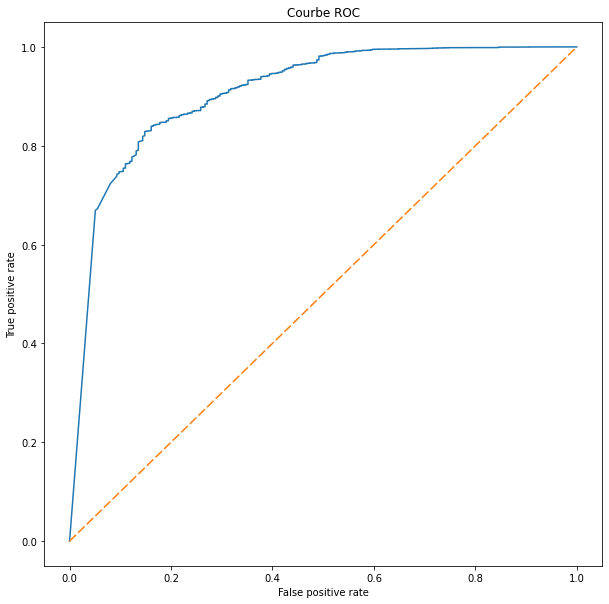

In [10]:
fpr, tpr, thresholds = metrics.roc_curve(true_classes, atis_test.iloc[:,4],pos_label=1)
print('AUC RNN = {:.4f}'.format(roc_auc_score(true_classes, atis_test.iloc[:,4])))
figure = plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.plot(np.arange(0,1.02,0.02),np.arange(0,1.02,0.02), dashes=[6, 2])
title = 'Courbe ROC'
plt.title(title) 
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

## Courbe Rappel-Précision

In [11]:
fpr, tpr, thresholds = metrics.precision_recall_curve(true_classes, atis_test.iloc[:,4],pos_label=1)
print('AUC RNN = {:.4f}'.format(roc_auc_score(true_classes, atis_test.iloc[:,4])))
figure = plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
title = 'Courbe Précision-Rappel'
plt.title(title) 
plt.xlabel('Rappel')
plt.grid()
plt.ylabel('Précision')

AUC RNN = 0.9077


Text(0, 0.5, 'Précision')

# Recherche des Clusters avec les densités

##### Les histogrammes sur lesquels on va inférer nos densités

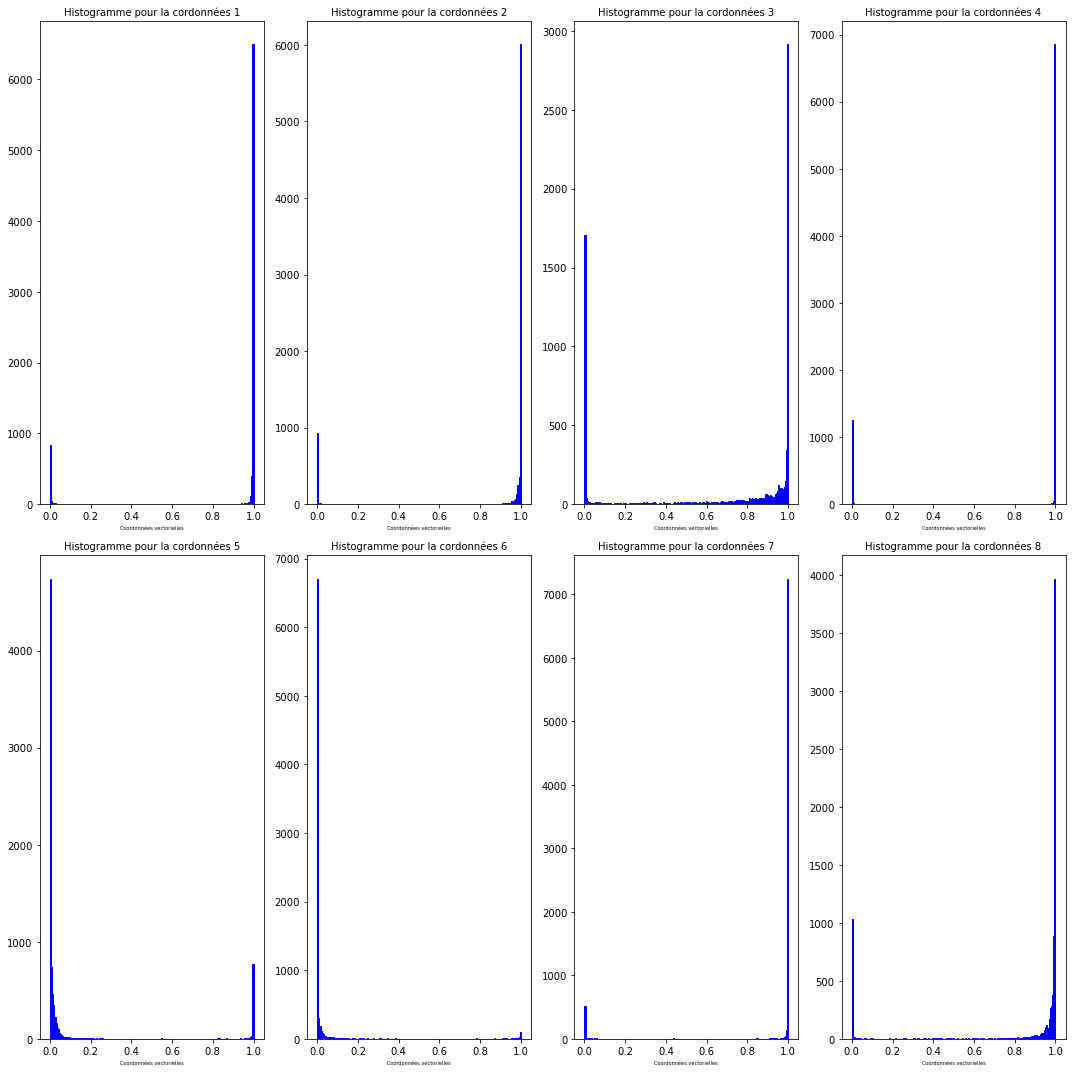

In [12]:
fig, ax = plt.subplots(figsize=(15,15))
for i in range(5,13):
    
    # Set up the plot
    ax = plt.subplot(2, 4, i-4)
    
    # Draw the plot
    ax.hist(atis_test.iloc[:,i], bins = 180,
             color = 'blue', edgecolor = 'blue')
    
    # Title and labels
    ax.set_title('Histogramme pour la cordonnées %d' % (i-4), size = 10)
    ax.set_xlabel('Coordonnées vectorielles', size = 5)

plt.tight_layout()
plt.show()

##### Et donc les densités estimées

In [13]:
fig, axes = plt.subplots(figsize=(20,10), ncols=2, nrows=4)
sns.kdeplot(atis_test.iloc[:,5], ax=axes[0,0]).set_title('Coordonées 1')
sns.kdeplot(atis_test.iloc[:,6], ax=axes[0,1]).set_title('Coordonées 2')
sns.kdeplot(atis_test.iloc[:,7], ax=axes[1,0]).set_title('Coordonées 3')
sns.kdeplot(atis_test.iloc[:,8], ax=axes[1,1]).set_title('Coordonées 4')
sns.kdeplot(atis_test.iloc[:,9], ax=axes[2,0]).set_title('Coordonées 5')
sns.kdeplot(atis_test.iloc[:,10], ax=axes[2,1]).set_title('Coordonées 6')
sns.kdeplot(atis_test.iloc[:,11], ax=axes[3,0]).set_title('Coordonées 7')
sns.kdeplot(atis_test.iloc[:,12], ax=axes[3,1]).set_title('Coordonées 8')

Text(0.5, 1.0, 'Coordonées 8')

### On cherche ici une estimation de la densité conjointe du vecteur. Le package nous donne directement les log-proba pour chaque individu. Si indépendance, on peut passer au produit des proba mais il faudrait pouvoir le montrer. 

Tout d'abord, il nous faut trouver le meilleur paramètre de bandwith car cela peut nous mener à plusieurs conclusions différentes. On choisit alors une manière empirique, implémentée dans Scikit-Learn qui est la cross validation. Dans la validation croisée, le modèle est ajusté à une partie des données, puis une mesure quantitative est calculée pour déterminer dans quelle mesure ce modèle s'adapte aux autres données. Une telle approche empirique de la sélection des paramètres du modèle est très flexible et peut être utilisée quelle que soit la distribution sous-jacente des données.

##### On va rajouter 100 composantes pour aider le classifieur à trouver les clusters, ces 100 valeurs sont les valeurs des densités pour chaque composante.

In [15]:
X_train = np.array(atis_train.iloc[:,5:105])
X_train

array([[9.9996221e-01, 9.9748248e-01, 9.9973375e-01, ..., 9.9998415e-01,
        9.9999416e-01, 1.1742372e-05],
       [9.9998856e-01, 9.9985158e-01, 9.8941630e-01, ..., 9.9996746e-01,
        9.9998915e-01, 8.3682324e-05],
       [9.9999523e-01, 9.9999630e-01, 8.2088435e-01, ..., 9.9993479e-01,
        9.9997282e-01, 1.5338463e-05],
       ...,
       [4.2560375e-03, 1.6651736e-08, 1.1838271e-03, ..., 9.9692589e-01,
        2.1049464e-02, 9.1958282e-05],
       [9.9734432e-01, 4.8908354e-03, 4.7374001e-06, ..., 1.9771784e-05,
        5.3235112e-07, 3.4549415e-02],
       [9.9993420e-01, 9.9985600e-01, 9.9689889e-01, ..., 9.9994230e-01,
        9.9998748e-01, 9.0217392e-05]], dtype=float32)

In [16]:
X_test = np.array(atis_test.iloc[:,5:105])
X_test

array([[9.9999619e-01, 9.9848515e-01, 7.7888465e-01, ..., 9.9633753e-01,
        9.9744499e-01, 5.1191655e-05],
       [9.9987543e-01, 9.9947673e-01, 9.1543090e-01, ..., 9.9996626e-01,
        9.9998915e-01, 6.2040781e-04],
       [9.9999452e-01, 9.9995065e-01, 8.4418160e-01, ..., 9.9996126e-01,
        9.9998844e-01, 9.7025892e-05],
       ...,
       [9.9967623e-01, 1.0000000e+00, 9.9999702e-01, ..., 9.9976128e-01,
        9.9999774e-01, 9.9908948e-01],
       [9.9999785e-01, 9.9999952e-01, 8.0973989e-01, ..., 9.9999642e-01,
        9.9999774e-01, 2.6148715e-05],
       [9.9987805e-01, 1.0000000e+00, 1.9184415e-07, ..., 1.5958264e-08,
        3.4884525e-07, 1.7850398e-05]], dtype=float32)

##### Cette fonction retourne les log-densités pour une v.a donnée

In [18]:
def kde_sklearn(x_train,x_test,kernel, bandwidth=1,**kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, kernel=kernel,**kwargs)
    kde_skl.fit(x_train)
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_test)
    return log_pdf

## Si l'on suppose l'indépendance, on peut multiplier les densités <=> Sommer les log-proba

##### GridCV pour trouver la meilleure Bandwidth et le meilleur Kernel + Calcul des log-densités pour chaque individu et chaque distribution

In [ ]:
dico = {}
for i in range(100) : 
    print('Densité {}'.format(i))
    grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 1, 7)},
                    cv=5) # 5-fold cross-validation
    x_train = X_train[:,i].reshape(-1, 1)
    x_test = X_test[:,i].reshape(-1, 1)
    grid.fit(x_train)
    dico[i] = kde_sklearn(x_train,x_test,'gaussian', grid.best_params_['bandwidth'])  

Densité 0
Densité 1
Densité 2
Densité 3
Densité 4
Densité 5
Densité 6
Densité 7
Densité 8
Densité 9
Densité 10
Densité 11
Densité 12
Densité 13


##### Ajout des log-densités pour chaque individu et chaque distribution

In [15]:
densite_inde = []
for i in range(len(atis_test.index)):
     densite_inde.append(0)
for i in range(len(atis_test.index)):
    for j in range(100):
        densite_inde[i] = densite_inde[i] + dico[j][i] 

In [16]:
densite_inde

[287.78182366548896,
 312.3561433252957,
 303.4646074661917,
 306.505374830214,
 302.3388341476816,
 313.09759562449227,
 313.6358991534386,
 291.9595530163794,
 247.24406280240456,
 292.2329191405537,
 283.8788893237503,
 297.6329469996264,
 321.0874076305431,
 308.392875343383,
 245.79822185647876,
 210.67781560339094,
 208.35176647774242,
 292.7122877128553,
 252.21723853913673,
 227.23699374521632,
 227.3725292840549,
 222.39999319738328,
 288.78125469863767,
 285.6540822306682,
 283.8652490308137,
 251.25695795724235,
 287.1292076006485,
 277.41277789881735,
 260.0529624731217,
 170.79496718094018,
 220.24723497173383,
 292.17152361904175,
 252.97607564698808,
 226.1129024735495,
 219.91502236527626,
 214.31435313815382,
 287.2810000205128,
 308.6375510104259,
 318.6786967195336,
 282.7622569795406,
 263.26324813813704,
 278.87222508568624,
 273.88586769719996,
 286.00131081333114,
 312.92025128513114,
 307.93663922265773,
 314.0482485677044,
 298.10199344753227,
 315.786474333056

#### Densité Conjointe

In [17]:
X = np.array(atis_test.iloc[:,5:105])

grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 1, 7)},
                    cv=5) # 5-fold cross-validation
grid.fit(X)

print(grid.best_params_)

kde = KernelDensity(bandwidth= grid.best_params_['bandwidth'],kernel='gaussian')
kde.fit(X)

densite_non_inde = kde.score_samples(X[:X.shape[0]])

{'bandwidth': 0.17500000000000002}


# Recherche des Clusters à partir de ces données

In [20]:
clusters = ['AC','AE','NC','NE']

In [21]:
X = np.array(atis_test.iloc[:,5:105])
y = np.array(atis_test.iloc[:,105])
X_200 = X.copy()
for i in range(100):
    X_200 = np.concatenate([X_200,dico[i].reshape(-1,1)],axis = 1)

In [22]:
X.shape, X_200.shape, y.shape

((8333, 100), (8333, 200), (8333,))

On va tester 3 cas :

    - 201 composantes avec la log-proba conjointe
    - 101 composantes avec la log-proba conjointe
    - 101 composantes avec la log-proba indé

##### 1)

In [23]:
X_1 = np.concatenate([X_200,densite_non_inde.reshape(-1,1)],axis = 1)

In [24]:
gbc = GradientBoostingClassifier(n_estimators=1000,verbose=1)
kfold = StratifiedKFold(n_splits=10) #5 split, trop long sur 10.
y_pred = cross_val_predict(gbc,X_1,y,cv=kfold,verbose=1,n_jobs = 2)
print(classification_report(y,y_pred,target_names = clusters, labels = clusters))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed: 1230.3min finished


              precision    recall  f1-score   support

          AC       0.97      0.99      0.98      7941
          AE       0.39      0.16      0.23       105
          NC       0.56      0.42      0.48       245
          NE       0.12      0.10      0.11        42

    accuracy                           0.96      8333
   macro avg       0.51      0.42      0.45      8333
weighted avg       0.95      0.96      0.95      8333



##### 2)

In [25]:
X_2 = np.concatenate([X,np.array(densite_non_inde).reshape(-1,1)],axis = 1)

In [26]:
gbc = GradientBoostingClassifier(n_estimators=1000,verbose=1)
kfold = StratifiedKFold(n_splits=10) #5 split, trop long sur 10.
y_pred = cross_val_predict(gbc,X_2,y,cv=kfold,verbose=1,n_jobs = 2)
print(classification_report(y,y_pred,target_names = clusters, labels = clusters))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed: 296.8min finished


              precision    recall  f1-score   support

          AC       0.97      0.99      0.98      7941
          AE       0.34      0.12      0.18       105
          NC       0.58      0.54      0.56       245
          NE       0.50      0.19      0.28        42

    accuracy                           0.96      8333
   macro avg       0.60      0.46      0.50      8333
weighted avg       0.95      0.96      0.95      8333



##### 3)

In [27]:
X_3 = np.concatenate([X,np.array(densite_inde).reshape(-1,1)],axis = 1)

In [28]:
gbc = GradientBoostingClassifier(n_estimators=1000,verbose=1)
kfold = StratifiedKFold(n_splits=10) #5 split, trop long sur 10.
y_pred = cross_val_predict(gbc,X_3,y,cv=kfold,verbose=1,n_jobs = 2)
print(classification_report(y,y_pred,target_names = clusters, labels = clusters))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed: 1127.3min finished


              precision    recall  f1-score   support

          AC       0.98      0.99      0.98      7941
          AE       0.42      0.14      0.21       105
          NC       0.64      0.55      0.59       245
          NE       0.29      0.19      0.23        42

    accuracy                           0.96      8333
   macro avg       0.58      0.47      0.50      8333
weighted avg       0.96      0.96      0.96      8333



# Essayer les classifieurs mais avec des nouvelles densités : cells où je prend pas les 'O' dès le calcul de ces densités

In [ ]:
X = np.array(atis_test[atis_test.iloc[:,2] != 'O'].iloc[:,5:105])

In [ ]:
#

In [ ]:
##### dico = densité une par une

In [ ]:
dico = {}
for i in range(100) : 
    print('Densité {}'.format(i))
    grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 1, 7)},
                    cv=5) # 5-fold cross-validation
    x = X[:,i].reshape(-1, 1)
    grid.fit(x)
    dico[i] = kde_sklearn(x,'gaussian', grid.best_params_['bandwidth'])  

In [ ]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 1, 7)},
                    cv=5) # 5-fold cross-validation
grid.fit(X)

print(grid.best_params_)

kde = KernelDensity(bandwidth= grid.best_params_['bandwidth'],kernel='gaussian')
kde.fit(X)

densite_non_inde = kde.score_samples(X[:X.shape[0]])

In [ ]:
y = np.array(atis_test.iloc[atis_test[atis_test.iloc[:,2] != 'O'].iloc[:,5:105].index,105])
X_200 = X.copy()
for i in range(100):
    X_200 = np.concatenate([X_200,dico[i].reshape(-1,1)],axis = 1)

##### 1)

In [ ]:
X_1 = np.concatenate([X_200,np.array(densite_non_inde).reshape(-1,1)],axis = 1)

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=500,verbose=1)
kfold = StratifiedKFold(n_splits=5) #5 split, trop long sur 10.
y_pred = cross_val_predict(gbc,X_1,y,cv=kfold,verbose=1,n_jobs = 2)
print(classification_report(y,y_pred,target_names = clusters, labels = clusters))

##### 2)

In [ ]:
X_2 = np.concatenate([X,np.array(densite_non_inde).reshape(-1,1)],axis = 1)

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=500,verbose=1)
kfold = StratifiedKFold(n_splits=5) #5 split, trop long sur 10.
y_pred = cross_val_predict(gbc,X_2,y,cv=kfold,verbose=1,n_jobs = 2)
print(classification_report(y,y_pred,target_names = clusters, labels = clusters))

##### 3)

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=500,verbose=1)
kfold = StratifiedKFold(n_splits=5) #5 split, trop long sur 10.
y_pred = cross_val_predict(gbc,X_200,y,cv=kfold,verbose=1,n_jobs = 2)
print(classification_report(y,y_pred,target_names = clusters, labels = clusters))